In [193]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import re
%matplotlib inline

# Get work postcode from user


In [259]:
user_pincode = input("Enter your work pincode here:")

Enter your work pincode here:W5 5AS


In [260]:
farezones = pd.read_csv("postcodes_latlong_districts_neareststations.csv")

#cleanup zone data
farezones['tube_zone'] = farezones['tube_zone'].str.replace("B", "9")
farezones['tube_zone'] = farezones['tube_zone'].str.replace("C", "9")
farezones['tube_zone'] = farezones['tube_zone'].str.replace("G", "9")
farezones['tube_zone'] = farezones['tube_zone'].str.replace("W", "9")
farezones['tube_zone'] = farezones['tube_zone'].str.replace("01-Feb", "2")
farezones['tube_zone'] = farezones['tube_zone'].str.replace("02-Mar", "3")
farezones['tube_zone'] = farezones['tube_zone'].str.replace("03-Apr", "4")
farezones['tube_zone'] = farezones['tube_zone'].str.replace("4/5", "5")
farezones['tube_zone'] = farezones['tube_zone'].str.replace("5/6", "6")
farezones['tube_zone'] = farezones['tube_zone'].str.replace("6/7", "7")
farezones['tube_zone'] = farezones['tube_zone'].str.replace("7/8", "8")
farezones['tube_zone'] = farezones['tube_zone'].str.replace("8/9", "9")
farezones.head()

,Unnamed: 0.1,Unnamed: 0,Postcode,Latitude,Longitude,Nearest_tube_station,tube_zone,Borough
0,0,0,BR1 1AA,51.401546,0.015415,Bromley South station,5,Bromley
1,1,1,BR1 1AB,51.406333,0.015208,Bromley North station,4,Bromley
2,2,2,BR1 1AD,51.400057,0.016715,Bromley South station,5,Bromley
3,3,3,BR1 1AE,51.404543,0.014195,Bromley South station,5,Bromley
4,4,4,BR1 1AF,51.401392,0.014948,Bromley South station,5,Bromley


# Calculate fare between user submitted postcodes to all London postcodes

In [261]:
#lets view user postcode info
user_info =farezones[farezones['Postcode']==user_pincode]
user_info

,Unnamed: 0.1,Unnamed: 0,Postcode,Latitude,Longitude,Nearest_tube_station,tube_zone,Borough
313936,313936,313936,W5 5AS,51.511856,-0.305624,Ealing Broadway station,3,Ealing


In [262]:
#lets fetch tube zone for user postcode
user_zone = user_info['tube_zone'].iloc[0]

#get tube fares
fares = pd.read_csv("tubefares_by_zone.csv")
monthlyfare = fares[fares['from zone'] == int(user_zone)]
#monthlyfare[monthlyfare['to zone'] == 5]['Monthly'].iloc[0]

In [263]:
zonelist = list(farezones['tube_zone'])
commutefare=[]
for zone in zonelist:
    commutefare.append(monthlyfare[monthlyfare['to zone'] == int(zone)]['Monthly'].iloc[0])

farezones['calculated_fare'] = commutefare

pivot_tubefares = farezones.pivot_table(index=['Borough'], values=['calculated_fare'], aggfunc={'median','mean','min'})

#mean_fare = pivot_tubefares.calculated_fare['mean']
pivot_tubefares.columns = pivot_tubefares.columns.droplevel(0) #remove amount
pivot_tubefares.columns.name = None               #remove categories
pivot_tubefares = pivot_tubefares.reset_index()
pivot_tubefares.head()

,Borough,mean,median,min
0,Barking and Dagenham,118.336879,122.5,110.6
1,Barnet,112.352087,110.6,110.6
2,Bexley,128.690579,122.5,110.6
3,Brent,110.600000,110.6,110.6
4,Bromley,124.243406,122.5,110.6


# Build a map to display monthly tube fare

In [265]:
#create a geodataframe
geometry = [Point(xy) for xy in zip(farezones["Longitude"], farezones["Latitude"])]
crs = "EPSG:4326"
fare_postcode_df = gpd.GeoDataFrame(farezones, crs=crs, geometry = geometry)

#Load the shapefile
fp = "statistical_gis_boundaries_london/ESRI/London_Borough_Excluding_MHW.shp"
map_df = gpd.read_file(fp)
map_df = map_df.to_crs(epsg=4326)
map_df.set_index('NAME')

#create merged dataframe to plot
map_fare_merged = map_df.set_index('NAME').join(pivot_tubefares.set_index('Borough'))
map_fare_merged = map_fare_merged.to_crs(epsg=4326)




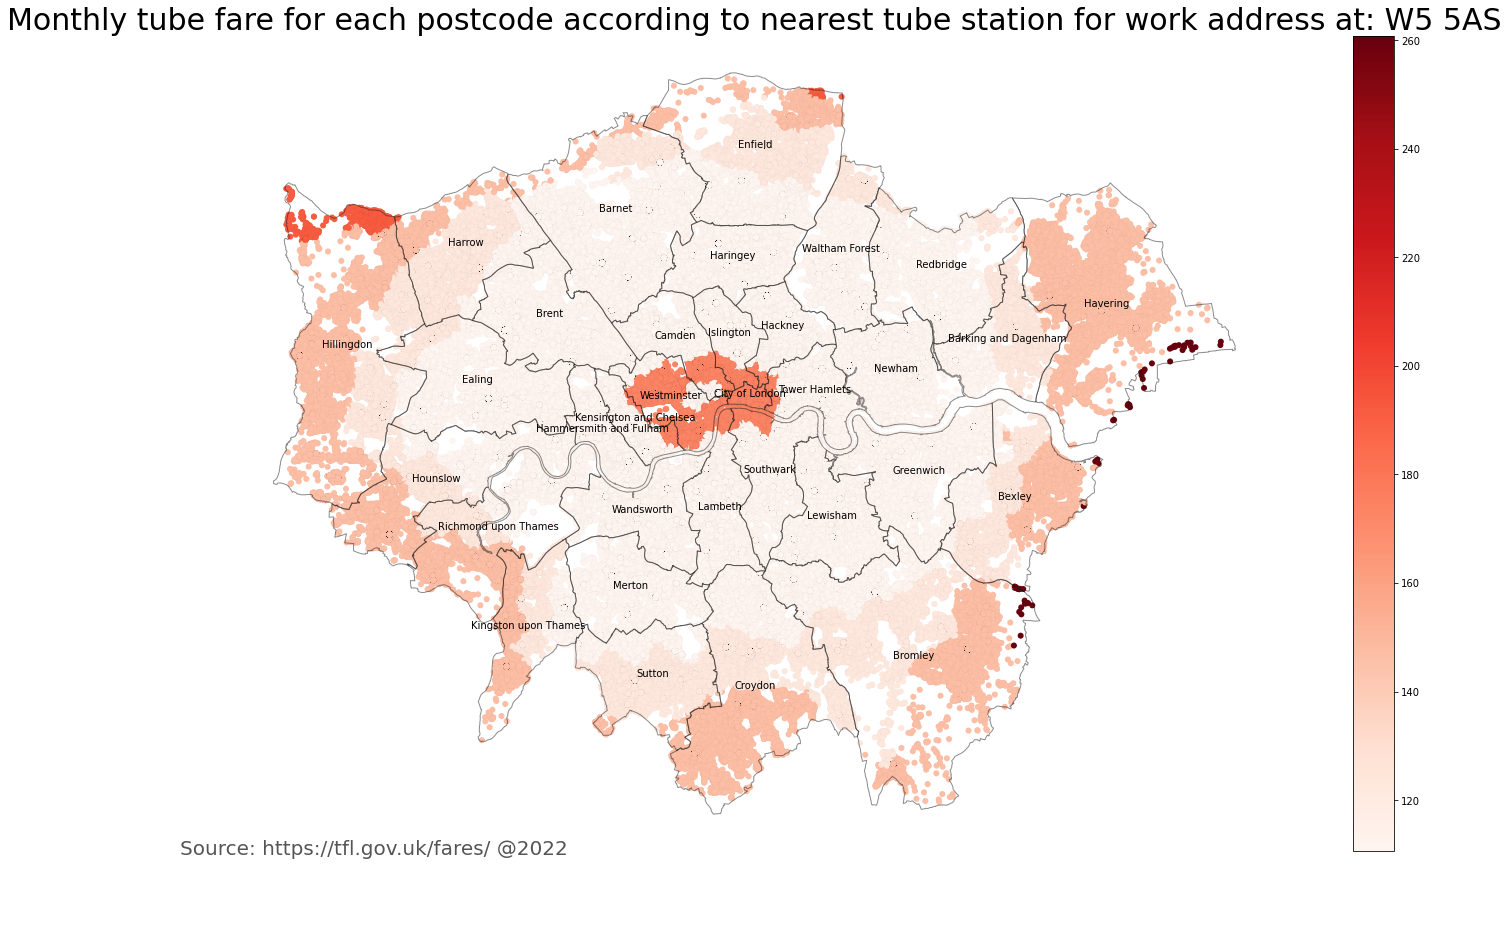

In [266]:
def plot_postcodesbyfare():
    vmin = min(fare_postcode_df['calculated_fare'])
    vmax = max(fare_postcode_df['calculated_fare'])
# create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize= (25, 15))
    ax.axis('off')
# add a title
    ax.set_title((f'Monthly tube fare for each postcode according to nearest tube station for work address at: {user_pincode}'), fontdict={'fontsize': '30', 'fontweight' : '5'})
# create an annotation for the data source
    ax.annotate('Source: https://tfl.gov.uk/fares/ @2022',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=20, color='#555555')
# Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
    sm._A = []
# add the colorbar to the figure
    cbar = fig.colorbar(sm)
# create map
    
    ax = fare_postcode_df.plot(column=fare_postcode_df['calculated_fare'],cmap='Reds', linewidth=0.008, ax=ax, edgecolor='0.1', zorder= 1)

    map_df.boundary.plot(linewidth=0.99, edgecolor='0.1',alpha=0.5, ax=ax, zorder=2)
    
    #add borough names
    map_df.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
    return plt.show()

plot_postcodesbyfare()


<AxesSubplot:title={'center':'Borough-wise Mean Monthly fare for work location: W5 5AS'}>

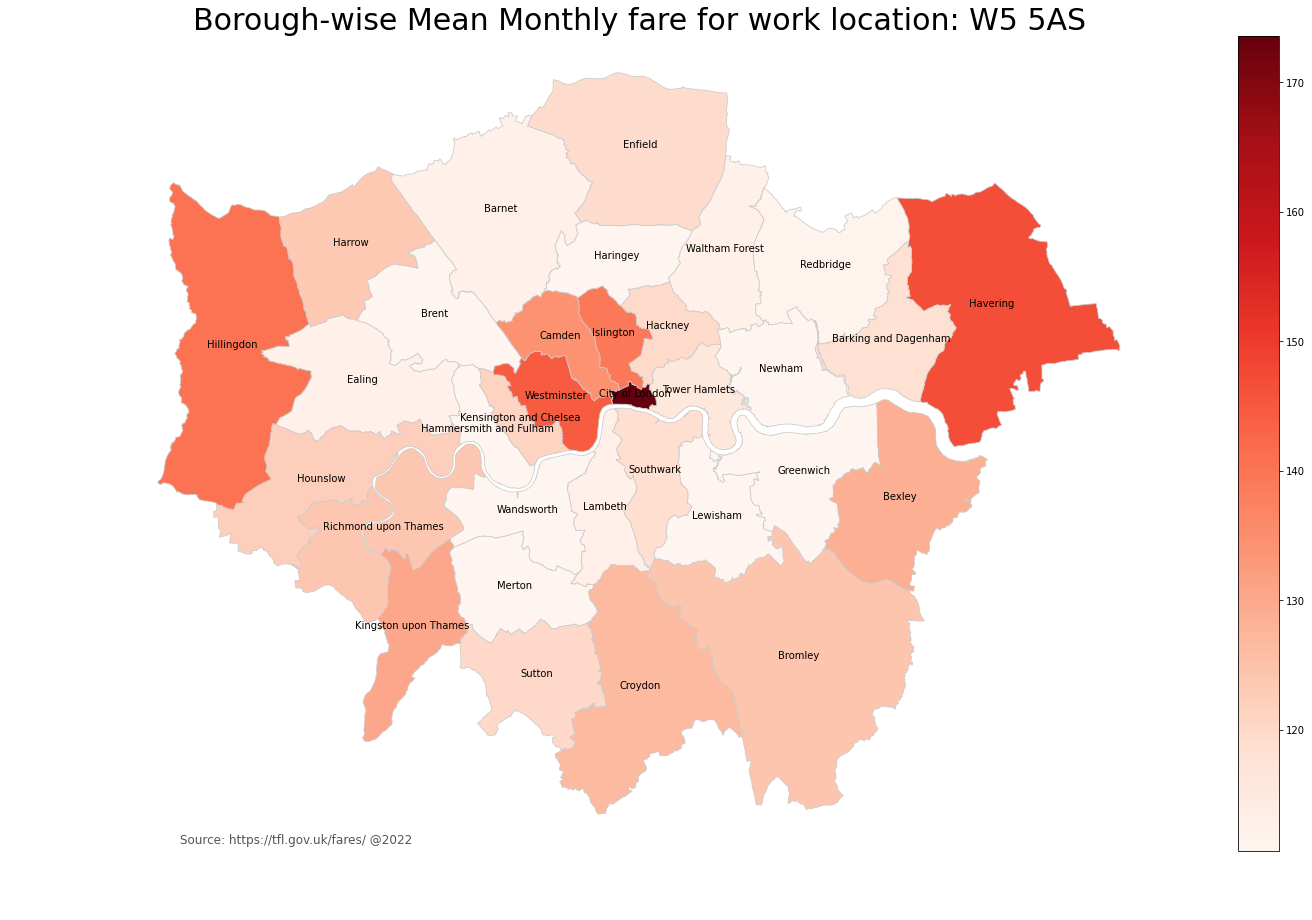

In [267]:
# set a variable that will call whatever column we want to visualise on the map
def plot_farebyboroughs():
    variable = 'mean'
# set the range for the choropleth
    vmin = min(map_fare_merged['mean'])
    vmax = max(map_fare_merged['mean'])
# create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(25, 15))
    ax.axis('off')
# add a title
    ax.set_title((f'Borough-wise Mean Monthly fare for work location: {user_pincode}'), fontdict={'fontsize': '30', 'fontweight' : '3'})
# create an annotation for the data source
    ax.annotate('Source: https://tfl.gov.uk/fares/ @2022',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
# Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
    sm._A = []
# add the colorbar to the figure
    cbar = fig.colorbar(sm)
# create map
    #add borough names
    map_df.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
    return map_fare_merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')


plot_farebyboroughs()

# Build a map to display monthly rent

In [155]:
#load the summarized rents for different types of properties saved earlier
onebhk = pd.read_csv("pivot_1bhk.csv") 
twobhk = pd.read_csv("pivot_2bhk.csv") 
threebhk = pd.read_csv("pivot_3bhk.csv") 
studio = pd.read_csv("pivot_studio.csv")
#make borough names uniform. This will be crucial for making the geodataframe. The easiest way is to sort alphabetically a list of borough names as used in the map_df and replace boroughs column by these entries.
Borough_names = map_df[['NAME']].sort_values(by='NAME').reset_index().drop('index', axis=1)

studio['Borough'] = Borough_names['NAME']
onebhk['Borough'] = Borough_names['NAME']
twobhk['Borough'] = Borough_names['NAME']
threebhk['Borough'] = Borough_names['NAME']

In [156]:
# join the data to be plotted with the geo dataframe created earlier
studio=studio.dropna(axis=0)
onebhk_merged = map_df.set_index('NAME').join(onebhk.set_index('Borough'))
twobhk_merged = map_df.set_index('NAME').join(twobhk.set_index('Borough'))
threebhk_merged = map_df.set_index('NAME').join(threebhk.set_index('Borough'))
studio_merged = map_df.set_index('NAME').join(studio.set_index('Borough'))

# 1. studio apartments

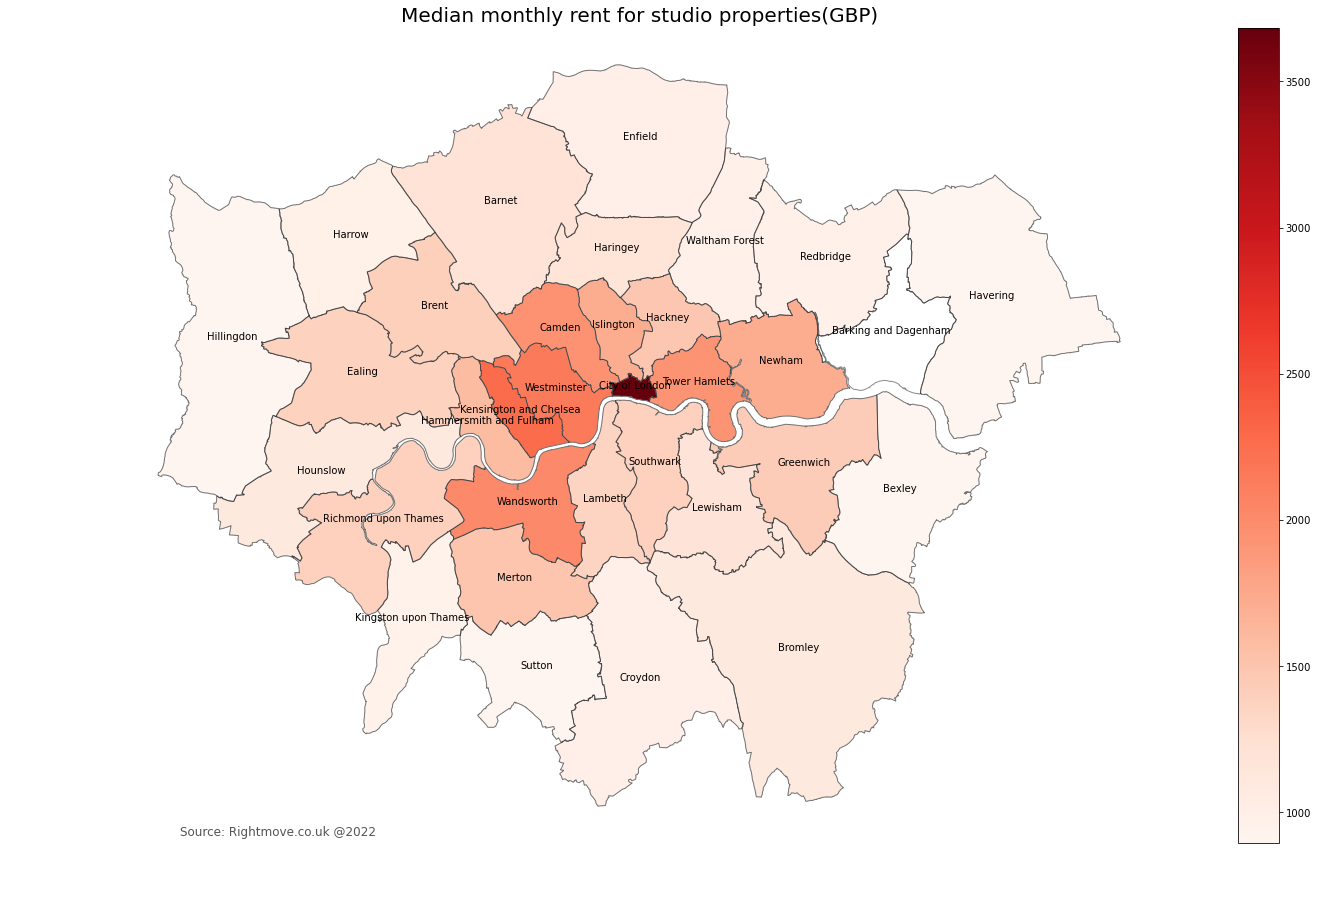

In [258]:

# set a variable that will call whatever column we want to visualise on the map
variable = 'median'
# set the range for the choropleth
vmin = min(studio['median'])
vmax = max(studio['median'])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(25, 15))
ax.axis('off')
# add a title
ax.set_title('Median monthly rent for studio properties(GBP)', fontdict={'fontsize': '20', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: Rightmove.co.uk @2022',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
#sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
# create map
studio_merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
map_df.boundary.plot(linewidth=0.99, edgecolor='0.1',alpha=0.5, ax=ax, zorder=2)
#add borough names
map_df.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
plt.show()

# 2. 1 bhk properties

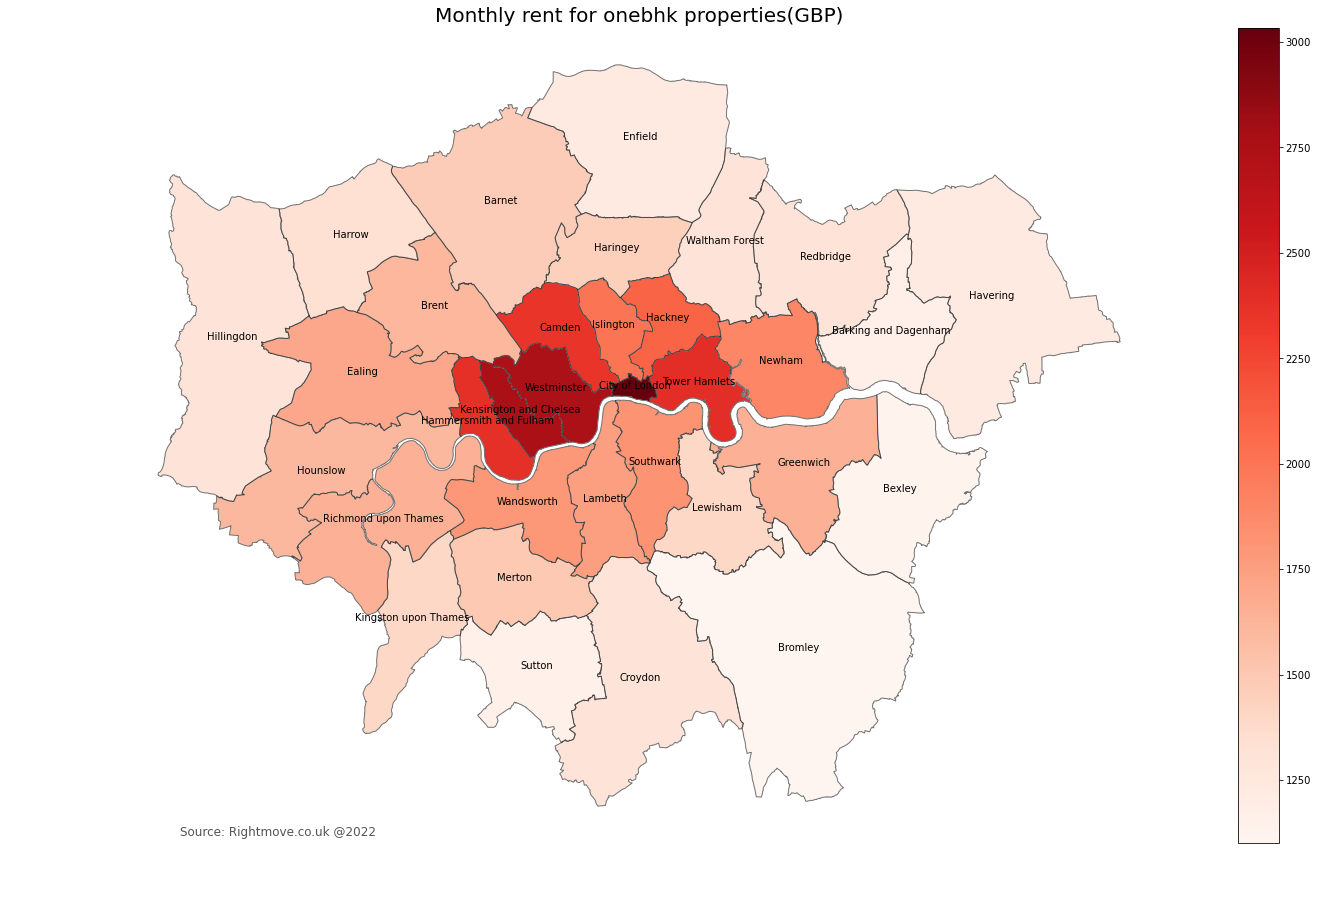

In [159]:

# set a variable that will call whatever column we want to visualise on the map
variable = 'median'
# set the range for the choropleth
vmin = min(onebhk['median'])
vmax = max(onebhk['median'])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(25, 15))
ax.axis('off')
# add a title
ax.set_title('Median monthly rent for 1bhk properties(GBP)', fontdict={'fontsize': '20', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: Rightmove.co.uk @2022',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
#sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
# create map
onebhk_merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
map_df.boundary.plot(linewidth=0.99, edgecolor='0.1',alpha=0.5, ax=ax, zorder=2)
#add borough names
map_df.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
plt.show()

# 3. 2 bhk properties

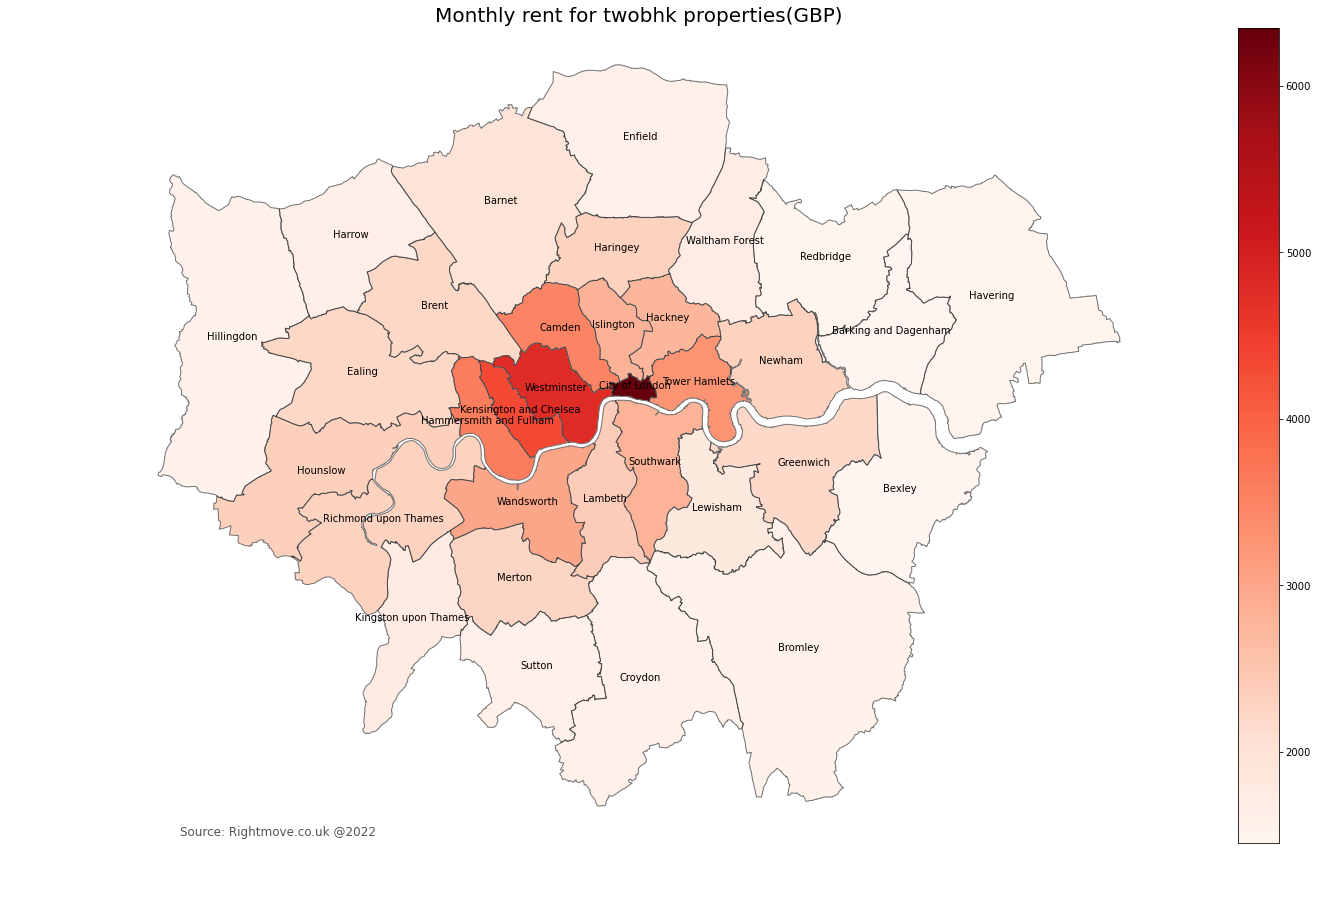

In [161]:

# set a variable that will call whatever column we want to visualise on the map
variable = 'median'
# set the range for the choropleth
vmin = min(twobhk['median'])
vmax = max(twobhk['median'])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(25, 15))
ax.axis('off')
# add a title
ax.set_title('Median monthly rent for 2bhk properties(GBP)', fontdict={'fontsize': '20', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: Rightmove.co.uk @2022',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
#sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
# create map
twobhk_merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
map_df.boundary.plot(linewidth=0.99, edgecolor='0.1',alpha=0.5, ax=ax, zorder=2)
#add borough names
map_df.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
plt.show()

# 4. 3 bhk properties

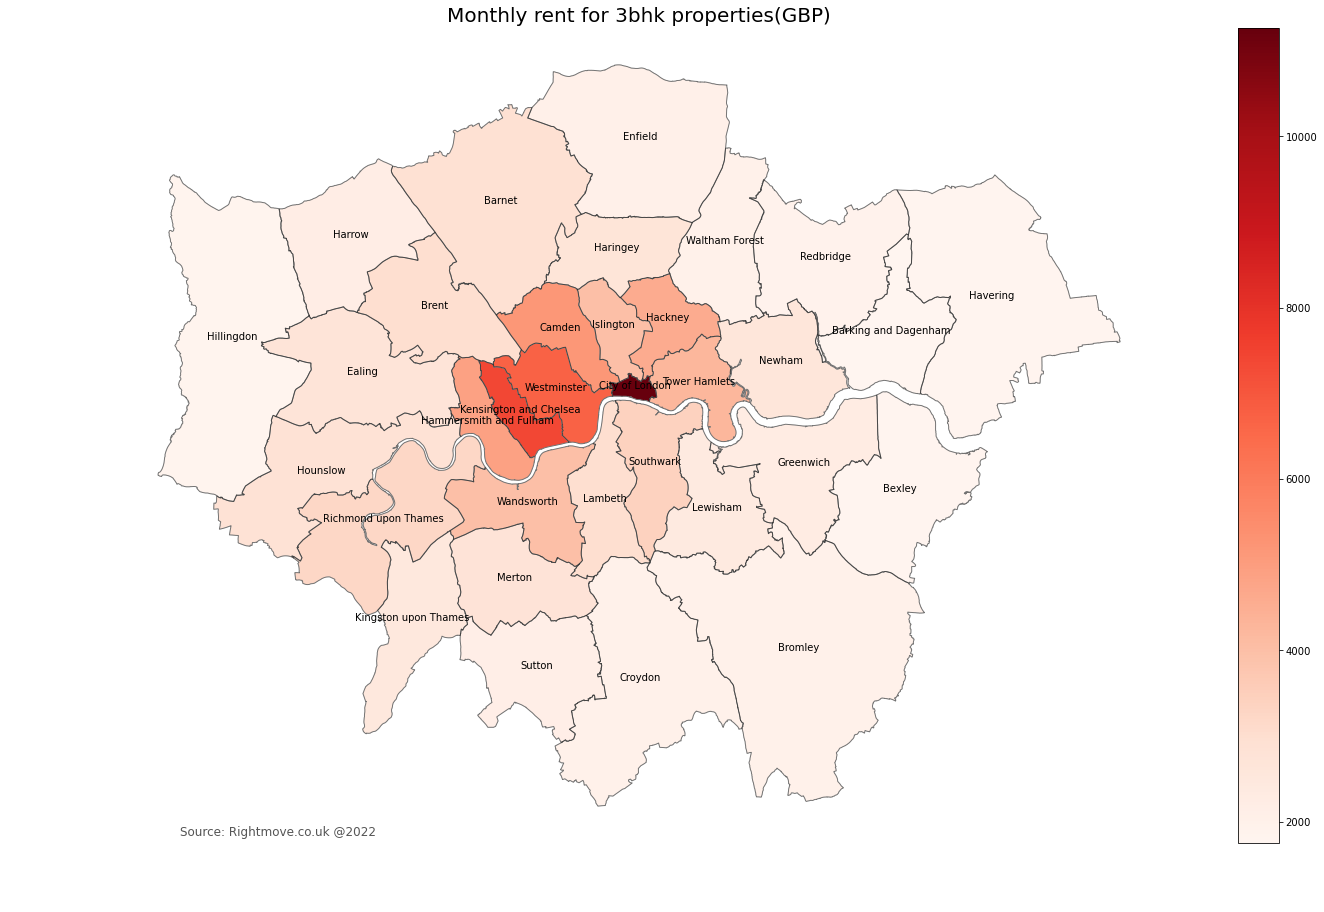

In [162]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'median'
# set the range for the choropleth
vmin = min(threebhk['median'])
vmax = max(threebhk['median'])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(25, 15))
ax.axis('off')
# add a title
ax.set_title('Median monthly rent for 3bhk properties(GBP)', fontdict={'fontsize': '20', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: Rightmove.co.uk @2022',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
#sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
# create map
threebhk_merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
map_df.boundary.plot(linewidth=0.99, edgecolor='0.1',alpha=0.5, ax=ax, zorder=2)
#add borough names
map_df.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
plt.show()

# 5. General rent data summary

In [190]:
data_summary= pd.DataFrame()
data_summary['studio']=studio_merged['median']
data_summary['onebhk']=onebhk_merged['median']
data_summary['twobhk']=twobhk_merged['median']
data_summary['threebhk']=threebhk_merged['median']
data_summary=data_summary.fillna(0)



Text(0, 0.5, 'Borough-wise median monthly rent in GBP')

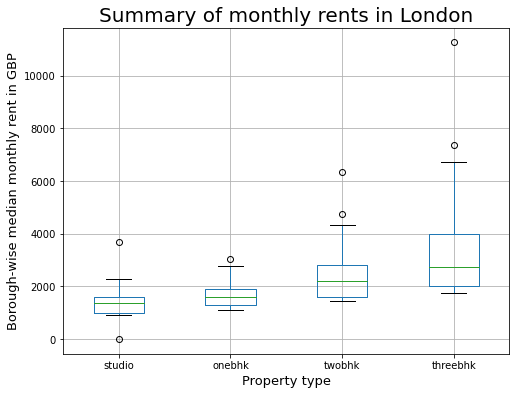

In [192]:
ax1= data_summary.boxplot(column=['studio', 'onebhk', 'twobhk', 'threebhk' ], figsize=(8,6))
ax1.set_title('Summary of monthly rents in London', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax1.set_xlabel('Property type', fontdict={'fontsize': '13', 'fontweight' : '3'})
ax1.set_ylabel('Borough-wise median monthly rent in GBP', fontdict={'fontsize': '13', 'fontweight' : '3'} )